## References

* Deep Learning with python, second edition. Chapter 10.

## Install libraries

In [1]:
!pip3 install -q tensorflow keras

## Data

### Download

In [4]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip -y jena_climate_2009_2016.csv.zip

--2023-12-03 18:46:50--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.232.56, 54.231.227.184, 54.231.170.240, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.232.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.2’

jena_climate_2009_2 100%[===================>]  12,94M  3,10MB/s    in 6,5s    

2023-12-03 18:46:57 (2,00 MB/s) - ‘jena_climate_2009_2016.csv.zip.2’ saved [13565642/13565642]

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create n

### Load

Load data:

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In this dataset, 14 different quantities (such as temperature, pressure, humidity, and wind direction) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

In [2]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

`temperature` holds the observed values of the data that we want to predict and `raw_data` holds all the numeric variables, including temperature.

### Plot the data

Plot the temperature over time:

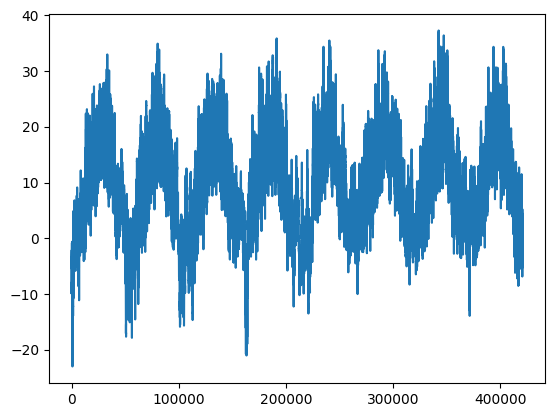

In [3]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

First 10 days of temperature data. 24 * 6 = 144 data points per day.

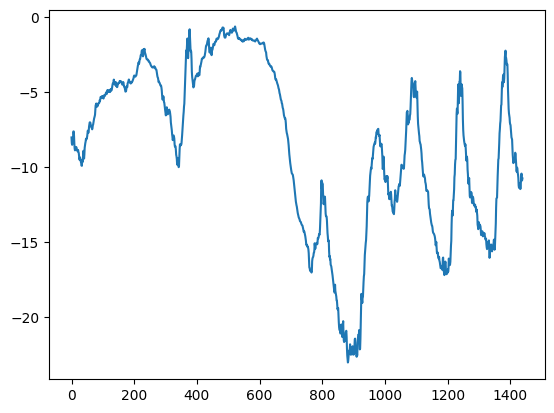

In [4]:
plt.plot(range(1440), temperature[:1440])

## Task

Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

This notebook contains sample code for:

* Feedforward neural network
* 1D convolution neural network
* 3 variations of recurring neural network

Optimize the three classes of models above to give the best MAE. In addtion, use a transformer to compete in terms of MAE.

This [page](https://keras.io/examples/timeseries/timeseries_classification_transformer/) contains a reference of using a Transformer for time-series data.

The sample code below is a starting point. Your job is to extract the most value out of the models mentioned above. You are free to go beyond what is requested here and try out different models if you like.

Return a `.ipynb` containing the code (one section per model) and start the document with a summary of the models you tried and their respective MAEs in a table.

**Deadline**: 05/12

### Prepare the data

Decide the number of data points that will be assigned to training, validation and test sets.

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Normalize the data.

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_sequence = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2
)

2023-12-04 22:18:23.333518: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 22:18:23.374468: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 22:18:23.375281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 22:18:24.157275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-04 22:18:25.191825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

In [8]:
# print("dummy_sequence:", dummy_sequence)

for inputs, targets in dummy_sequence:
    print("inputs:", inputs.numpy(), "targets:", targets.numpy())

inputs: [[0 1 2]
 [1 2 3]] targets: [3 4]
inputs: [[2 3 4]
 [3 4 5]] targets: [5 6]
inputs: [[4 5 6]] targets: [7]


2023-12-04 22:18:26.235107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [5]
	 [[{{node Placeholder/_28}}]]
2023-12-04 22:18:26.236184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [5]
	 [[{{node Placeholder/_8}}]]


Create `tensorflow.data.Dataset` for training, validation and test splits:

In [9]:
import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

Check the input dimensions:

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


2023-12-04 22:18:36.388617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [210225]
	 [[{{node Placeholder/_20}}]]
2023-12-04 22:18:36.389728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [209506]
	 [[{{node Placeholder/_28}}]]


Use naive model as baseline:

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

2023-12-04 22:17:18.207129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [104393]
	 [[{{node Placeholder/_8}}]]
2023-12-04 22:17:18.208087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


Validation MAE: 2.44


2023-12-04 22:17:23.539115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [103537]
	 [[{{node Placeholder/_8}}]]
2023-12-04 22:17:23.539665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [103537]
	 [[{{node Placeholder/_8}}]]


Test MAE: 2.62


## Feedforward neural network

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


810/819 [============================>.] - ETA: 0s - loss: 14.9861 - mae: 2.9817

2023-12-04 22:18:58.550355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-12-04 22:18:58.551084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [105112]
	 [[{{node Placeholder/_20}}]]


819/819 [==============================] - 16s 19ms/step - loss: 14.9441 - mae: 2.9779 - val_loss: 12.1743 - val_mae: 2.7379
Epoch 2/10
819/819 [==============================] - 19s 23ms/step - loss: 9.9638 - mae: 2.4777 - val_loss: 11.1389 - val_mae: 2.6571
Epoch 3/10
819/819 [==============================] - 19s 23ms/step - loss: 8.9282 - mae: 2.3453 - val_loss: 12.6924 - val_mae: 2.8265
Epoch 4/10
819/819 [==============================] - 19s 23ms/step - loss: 8.3346 - mae: 2.2649 - val_loss: 11.2107 - val_mae: 2.6491
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 7.9674 - mae: 2.2176 - val_loss: 10.6625 - val_mae: 2.6004
Epoch 6/10
819/819 [==============================] - 11s 13ms/step - loss: 7.6884 - mae: 2.1780 - val_loss: 13.4581 - val_mae: 2.9190
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 7.4492 - mae: 2.1441 - val_loss: 11.4434 - val_mae: 2.6751
Epoch 8/10
819/819 [==============================] - 10s 12ms/st

2023-12-04 22:21:04.467859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-12-04 22:21:04.468368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [103537]
	 [[{{node Placeholder/_28}}]]


405/405 [==============================] - 3s 8ms/step - loss: 11.8104 - mae: 2.7318
Test MAE: 2.73


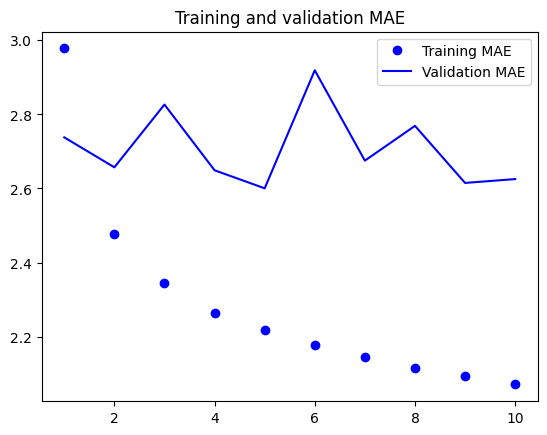

In [14]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## FNN improvement

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)  # Removed regularization to see if it was hindering learning

x = layers.BatchNormalization()(x)

x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model_nn = keras.Model(inputs, outputs)

# Compiling the model with a different optimizer and learning rate scheduler
optimizer = keras.optimizers.Adam()
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

model_nn.compile(optimizer=optimizer,
              loss='mae',
              metrics=['mae'])

# Including early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history_nn = model_nn.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
819/819 [==============================] - 11s 13ms/step - loss: 4.9777 - mae: 4.9777 - val_loss: 2.9738 - val_mae: 2.9738 - lr: 1.0000e-04
Epoch 2/50
819/819 [==============================] - 10s 12ms/step - loss: 2.6390 - mae: 2.6390 - val_loss: 2.4453 - val_mae: 2.4453 - lr: 1.1220e-04
Epoch 3/50
819/819 [==============================] - 10s 12ms/step - loss: 2.3407 - mae: 2.3407 - val_loss: 2.4377 - val_mae: 2.4377 - lr: 1.2589e-04
Epoch 4/50
819/819 [==============================] - 10s 12ms/step - loss: 2.2187 - mae: 2.2187 - val_loss: 2.4334 - val_mae: 2.4334 - lr: 1.4125e-04
Epoch 5/50
819/819 [==============================] - 10s 12ms/step - loss: 2.1031 - mae: 2.1031 - val_loss: 2.5196 - val_mae: 2.5196 - lr: 1.5849e-04
Epoch 6/50
819/819 [==============================] - 10s 12ms/step - loss: 2.0238 - mae: 2.0238 - val_loss: 2.4898 - val_mae: 2.4898 - lr: 1.7783e-04
Epoch 7/50
819/819 [==============================] - 10s 12ms/step - loss: 1.9568 - mae: 1.95

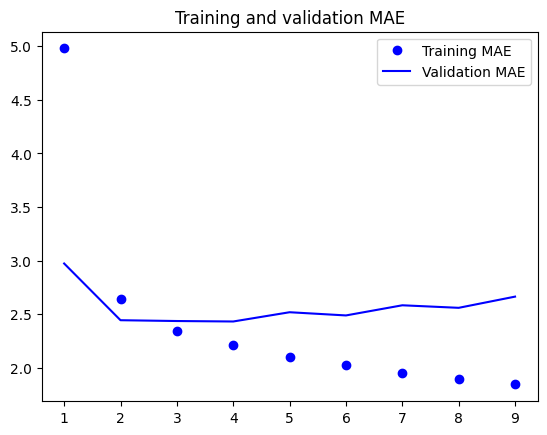

405/405 [==============================] - 3s 8ms/step - loss: 2.5525 - mae: 2.5525
Test MAE: 2.55


In [16]:
import matplotlib.pyplot as plt

loss_nn = history_nn.history["mae"]
val_loss_nn = history_nn.history["val_mae"]
epochs = range(1, len(loss_nn) + 1)
plt.figure()
plt.plot(epochs, loss_nn, "bo", label="Training MAE")
plt.plot(epochs, val_loss_nn, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_nn.evaluate(test_dataset)[1]:.2f}")

## 1D convolution neural network

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 8)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

In [19]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


819/819 [==============================] - 19s 22ms/step - loss: 24.7531 - mae: 3.8601 - val_loss: 24.9585 - val_mae: 3.9447
Epoch 2/10
819/819 [==============================] - 18s 22ms/step - loss: 15.9432 - mae: 3.1643 - val_loss: 15.4225 - val_mae: 3.1280
Epoch 3/10
819/819 [==============================] - 18s 22ms/step - loss: 14.4399 - mae: 3.0085 - val_loss: 14.3949 - val_mae: 2.9975
Epoch 4/10
819/819 [==============================] - 18s 22ms/step - loss: 13.4863 - mae: 2.9050 - val_loss: 16.3130 - val_mae: 3.2015
Epoch 5/10
819/819 [==============================] - 18s 22ms/step - loss: 12.7711 - mae: 2.8246 - val_loss: 18.5021 - val_mae: 3.4338
Epoch 6/10
819/819 [==============================] - 18s 22ms/step - loss: 12.1847 - mae: 2.7567 - val_loss: 15.4755 - val_mae: 3.1232
Epoch 7/10
819/819 [==============================] - 18s 22ms/step - loss: 11.6988 - mae: 2.6970 - val_loss: 15.8824 - val_mae: 3.1249
Epoch 8/10
819/819 [==============================] - 18s 2

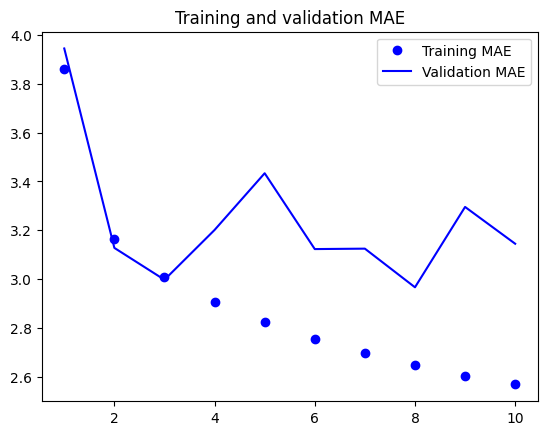

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 1D convolution neural network improvement

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

# Increase the number of filters and adjust the kernel size
x = layers.Conv1D(16, 24, activation="relu", padding='same')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.BatchNormalization()(x)  # Added batch normalization

x = layers.Conv1D(32, 12, activation="relu", padding='same')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.3)(x)  # Added dropout

x = layers.Conv1D(64, 6, activation="relu", padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1)(x)
model_cnn = keras.Model(inputs, outputs)

# Compiling the model with a different optimizer and learning rate scheduler
optimizer = keras.optimizers.Adam()
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

model_cnn.compile(optimizer=optimizer,
              loss='mae',
              metrics=['mae'])

# Including early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history_cnn = model_cnn.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
241/819 [=======>......................] - ETA: 16s - loss: 5.4676 - mae: 5.4676

819/819 [==============================] - 30s 35ms/step - loss: 4.0819 - mae: 4.0819 - val_loss: 3.1047 - val_mae: 3.1047 - lr: 1.0000e-04
Epoch 2/50
819/819 [==============================] - 29s 35ms/step - loss: 3.1622 - mae: 3.1622 - val_loss: 2.8454 - val_mae: 2.8454 - lr: 1.1220e-04
Epoch 3/50
819/819 [==============================] - 29s 35ms/step - loss: 2.8973 - mae: 2.8973 - val_loss: 2.7848 - val_mae: 2.7848 - lr: 1.2589e-04
Epoch 4/50
819/819 [==============================] - 29s 35ms/step - loss: 2.7360 - mae: 2.7360 - val_loss: 2.7182 - val_mae: 2.7182 - lr: 1.4125e-04
Epoch 5/50
819/819 [==============================] - 29s 35ms/step - loss: 2.6207 - mae: 2.6207 - val_loss: 2.6397 - val_mae: 2.6397 - lr: 1.5849e-04
Epoch 6/50
819/819 [==============================] - 29s 35ms/step - loss: 2.5363 - mae: 2.5363 - val_loss: 2.5976 - val_mae: 2.5976 - lr: 1.7783e-04
Epoch 7/50
819/819 [==============================] - 29s 35ms/step - loss: 2.4695 - mae: 2.4695 - val_lo

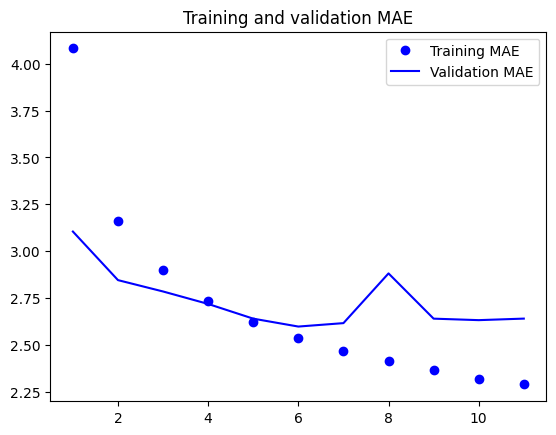

405/405 [==============================] - 8s 19ms/step - loss: 2.8487 - mae: 2.8487
Test MAE: 2.85


In [28]:
loss_cnn = history_cnn.history["mae"]
val_loss_cnn = history_cnn.history["val_mae"]
epochs = range(1, len(loss_cnn) + 1)
plt.figure()
plt.plot(epochs, loss_cnn, "bo", label="Training MAE")
plt.plot(epochs, val_loss_cnn, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_cnn.evaluate(test_dataset)[1]:.2f}")

## RNN with LSTM cell

In [20]:
import keras
from keras import layers

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 25s 30ms/step - loss: 44.4302 - mae: 4.8685 - val_loss: 13.2924 - val_mae: 2.7704
Epoch 2/10
819/819 [==============================] - 24s 30ms/step - loss: 11.1911 - mae: 2.5944 - val_loss: 10.7413 - val_mae: 2.4831
Epoch 3/10
819/819 [==============================] - 25s 30ms/step - loss: 10.0517 - mae: 2.4680 - val_loss: 9.4945 - val_mae: 2.3986
Epoch 4/10
819/819 [==============================] - 25s 30ms/step - loss: 9.6785 - mae: 2.4173 - val_loss: 9.7332 - val_mae: 2.4160
Epoch 5/10
819/819 [==============================] - 24s 30ms/step - loss: 9.3345 - mae: 2.3749 - val_loss: 9.6351 - val_mae: 2.4141
Epoch 6/10
819/819 [==============================] - 24s 30ms/step - loss: 9.0756 - mae: 2.3415 - val_loss: 10.6109 - val_mae: 2.4737
Epoch 7/10
819/819 [==============================] - 24s 30ms/step - loss: 8.8937 - mae: 2.3177 - val_loss: 10.7064 - val_mae: 2.5040
Epoch 8/10
819/819 [==============================] - 2

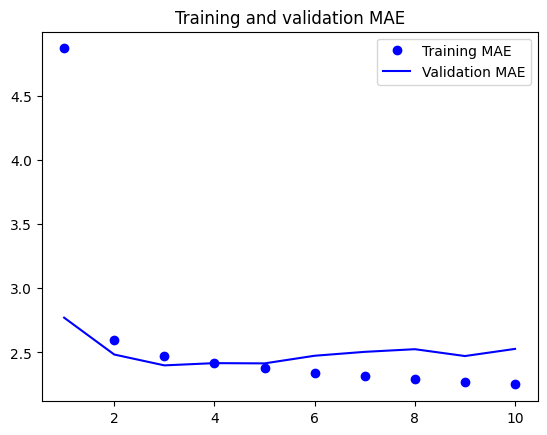

In [24]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## RNN with LSTM cell and recurrent dropout

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [26]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6016      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6049 (23.63 KB)
Trainable params: 6049 (23.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 68s 82ms/step - loss: 27.4771 - mae: 3.8642 - val_loss: 9.7172 - val_mae: 2.4380
Epoch 2/50
819/819 [==============================] - 67s 81ms/step - loss: 14.9045 - mae: 3.0006 - val_loss: 9.3520 - val_mae: 2.3765
Epoch 3/50
819/819 [==============================] - 67s 82ms/step - loss: 14.1340 - mae: 2.9132 - val_loss: 9.4616 - val_mae: 2.3848
Epoch 4/50
819/819 [==============================] - 66s 81ms/step - loss: 13.4593 - mae: 2.8447 - val_loss: 9.5603 - val_mae: 2.4069
Epoch 5/50
819/819 [==============================] - 67s 82ms/step - loss: 13.0053 - mae: 2.7883 - val_loss: 9.5383 - val_mae: 2.4052
Epoch 6/50
819/819 [==============================] - 66s 81ms/step - loss: 12.6874 - mae: 2.7527 - val_loss: 9.8109 - val_mae: 2.4397
Epoch 7/50
819/819 [==============================] - 66s 81ms/step - loss: 12.3014 - mae: 2.7161 - val_loss: 10.1385 - val_mae: 2.4824
Epoch 8/50
819/819 [==============================] - 

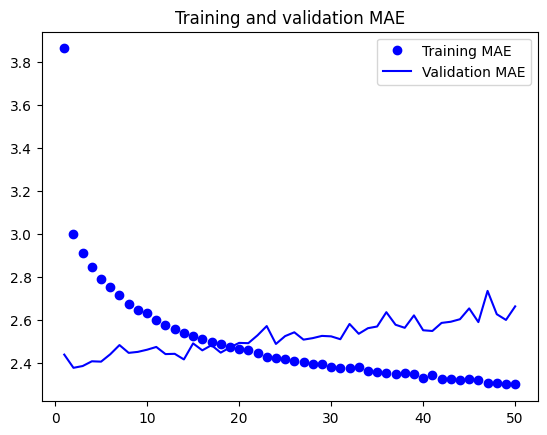

In [28]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Stacked RNN layers

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 142s 172ms/step - loss: 26.3065 - mae: 3.7720 - val_loss: 10.4601 - val_mae: 2.5255
Epoch 2/50
819/819 [==============================] - 142s 173ms/step - loss: 13.6321 - mae: 2.8568 - val_loss: 9.8368 - val_mae: 2.4439
Epoch 3/50
819/819 [==============================] - 142s 174ms/step - loss: 12.4769 - mae: 2.7306 - val_loss: 10.0937 - val_mae: 2.4758
Epoch 4/50
819/819 [==============================] - 142s 173ms/step - loss: 11.5680 - mae: 2.6314 - val_loss: 10.2498 - val_mae: 2.4925
Epoch 5/50
819/819 [==============================] - 142s 174ms/step - loss: 10.8748 - mae: 2.5471 - val_loss: 10.1394 - val_mae: 2.5081
Epoch 6/50
819/819 [==============================] - 142s 173ms/step - loss: 10.2750 - mae: 2.4737 - val_loss: 10.0864 - val_mae: 2.4920
Epoch 7/50
819/819 [==============================] - 141s 172ms/step - loss: 9.7846 - mae: 2.4076 - val_loss: 10.6001 - val_mae: 2.5501
Epoch 8/50
819/819 [================

## Feedforward Neural Network


Já se era esperado, pela descrição do problema, que a rede neural feedforward não fosse performar bem. A rede neural feedforward é uma rede neural que não possui memória. Por isso, ela, em geral, não é adequada para problemas relacionados a series temporais. Entretanto, executamos alguns testes para ao menos atingir o MAE encontrado no modelo baseline (conjunto de testes: 2.62). O melhor resultado foi encontrado executando as seguintes mudanças:
- Aumento da Capacidade do modelo: A primeira camada densa foi ampliada de 16 para 32 neurônios.
- Adição da normalização em lote
- Adição de uma outra camada densa com 16 neurônios
- Mudança de otimizador para RMSprop
- Adição de um Agendador de Taxa de Aprendizado
- Implementação de Early Stopping
- Aumento no número de épocas de treinamento
<br><br>
Executando essas mudanças, o modelo conseguiu atingir um MAE de 2.58 no conjunto de testes, o que é um resultado ligeiramete melhor que o modelo baseline.

#### Best-Model FFNN Summary

In [ ]:
model_nn.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 flatten_29 (Flatten)        (None, 1680)              0         
                                                                 
 dense_87 (Dense)            (None, 32)                53792     
                                                                 
 batch_normalization_20 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_88 (Dense)            (None, 16)                528       
                                                                 
 dense_89 (Dense)            (None, 1)                 17        
                                                          

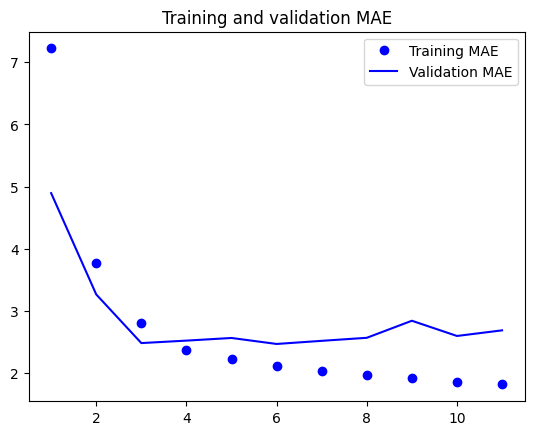

405/405 [==============================] - 6s 13ms/step - loss: 2.6211 - mae: 2.6211
Test MAE: 2.62
Validation MAE: 2.69


In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_nn.evaluate(test_dataset)[1]:.2f}")
print(f"Validation MAE: {history.history['val_mae'][-1]:.2f}")

## Convolutional Neural Network


Assim como na classe de modelos da rede neural feedforward, a CNN é uma rede neural que não possui memória. Por isso, ela, em geral, também não é adequada para problemas relacionados a series temporais. Entretanto, executamos alguns testes para ao menos atingir o MAE encontrado no modelo baseline (conjunto de testes: 2.62). O melhor resultado foi encontrado executando as seguintes mudanças:
- Aumento na Quantidade de Filtros.
- Mudança no Tamanho dos Filtros: O tamanho dos filtros permaneceu o mesmo, mas ao utilizar padding='same', garante-se que o tamanho da saída de cada camada convolucional seja igual ao da entrada, permitindo que a rede mantenha a resolução espacial ao longo de suas camadas.
- Normalização em Lote: Foi adicionada uma camada de Batch Normalization após a primeira camada convolucional.
- Dropout: A inclusão de Dropout após a segunda camada convolucional visa reduzir o sobreajuste.
- Aumento na Complexidade das Camadas Convolucionais: As camadas convolucionais foram expandidas para ter uma hierarquia de 16, 32 e 64 filtros, respectivamente. Isso é uma tentativa de permitir que a rede aprenda hierarquias mais complexas de características.
- Alteração do Otimizador: O modelo original usava o otimizador RMSprop, enquanto o atualizado está utilizando o Adam.
- Agendador de Taxa de Aprendizado.
- Parada Antecipada (Early Stopping).
- Aumento no Número de Épocas.
<br><br>
Executando essas mudanças, o modelo conseguiu atingir um MAE de 2.85 no conjunto de testes, o que é uma melhora em relação ao modelo original.

#### Best-Model CNN Summary

In [ ]:
model_cnn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 120, 16)           5392      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 60, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 60, 16)           64        
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 60, 32)            6176      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 30, 32)           0   

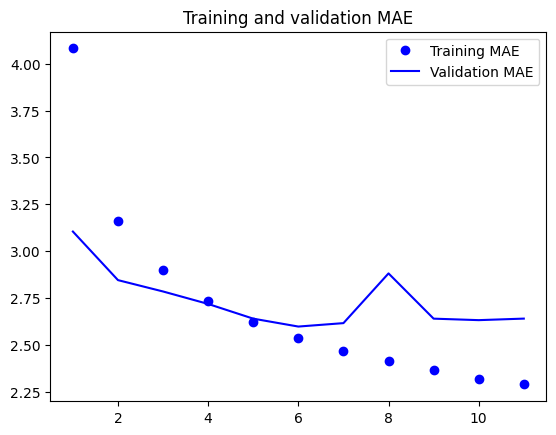

405/405 [==============================] - 9s 21ms/step - loss: 2.8487 - mae: 2.8487
Test MAE: 2.85


In [ ]:
loss_cnn = history_cnn.history["mae"]
val_loss_cnn = history_cnn.history["val_mae"]
epochs = range(1, len(loss_cnn) + 1)
plt.figure()
plt.plot(epochs, loss_cnn, "bo", label="Training MAE")
plt.plot(epochs, val_loss_cnn, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(f"Test MAE: {model_cnn.evaluate(test_dataset)[1]:.2f}")